In [31]:
import time
import os
import random
#import matplotlib.pyplot as plt; plt.rcdefaults()
from subprocess import Popen, PIPE
import sqlite3
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import json

In [2]:
#size
B = 1
KB = 1024 * B
MB = 1024 * KB
GB = 1024 * MB
TB = 1024 * GB

#test result
LOG_RES_P50 = "P50"
LOG_RES_P75 = "P75"
LOG_RES_P99 = "P99"
LOG_RES_P999 = "P99.9"
LOG_RES_P9999 = "P99.99"
LOG_RES_MICORS_OP = "micros/op"
LOG_RES_OPS_SEC = "ops/sec"
LOG_RES_RES_LINE = "Result Line"
LOG_RES_DELAY_LINE = "Delay Line"
LOG_RES_THROUGHPUT = "MB/s"

#test case config
CONFIG_KEY_SIZE = "KeySize"
CONFIG_VALUE_SIZE = "ValueSize"
CONFIG_VM_CACHE_MODE = "VMCacheMode"
CONFIG_TEST_CASE_NAME = "TestCaseName"
CONFIG_ROCKSDB_PARAMETERS = "RocksDB_Parameters"

#dir and file name
PERFORMANCE_RES_DIR_NAME = "performance-testing-log"
PERFORMANCE_RESULT_POSTFIX = "performance-result"


#Benchmark Parameters
parameter_bulkload = f"--disable_auto_compactions=1 \
                       --sync=0 \
                       --threads=1 \
                       --memtablerep=vector \
                       --allow_concurrent_memtable_write=false \
                       --disable_wal=1 "

In [3]:

#command line tool
def run_cmd(cmd, throw_exception = False):
    p = Popen(cmd , shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    out_str = out.decode("utf-8")
    err_str = err.decode("utf-8")
    if(throw_exception and err_str != ''):
        return err_str
    return out_str

In [4]:


class Result():
    def __init__(self, res_map = {}):
        self.res_map = res_map
        
    def put_res(self, key, value):
        self.res_map[key] = value
    
    def put_all_res(self, res_map):
        self.res_map.update(res_map)
    

class LogParser():
    def __init__(self, log = None, file_name = None):
        if file_name != None:
            log = open(file_name, 'r').read() 
        self.log = log
        self.lines = log.split("\n")    

    def parse_all(self, res = None):
        self.base_res_line = None
        self.delay_percentiles_line = None
        for line in self.lines:
            self.extract_basic_res_line(line)
            self.extract_delay_percentiles_line(line)
        if res != None:
            res.put_all_res(self.get_basic_res())
            res.put_all_res(self.get_percentiles())

    def extract_basic_res_line(self, line):
        if self.base_res_line == None and "micros/op" in line and "ops/sec" in line:
            self.base_res_line = line

    def extract_delay_percentiles_line(self, line):
        if self.delay_percentiles_line == None and line.startswith("Percentiles: P50"):
            self.delay_percentiles_line = line

    def dump(self):
        print(self.base_res_line)
        print(self.delay_percentiles_line)

    def get_basic_res(self):
        d = self.extract_float(self.base_res_line)
        #print(self.base_res_line)
        #print(d)
        return self.convert_to_dict([LOG_RES_MICORS_OP, LOG_RES_OPS_SEC, LOG_RES_THROUGHPUT], d)

    def get_percentiles(self):
        return self.convert_to_dict([LOG_RES_P50, LOG_RES_P75, LOG_RES_P99, LOG_RES_P999, LOG_RES_P9999],
                                    self.extract_float(self.delay_percentiles_line))
    
    def extract_
    
    def extract_float(self, line):
        strs = line.split(" ")
        res_list = []
        for s in strs:
            if self.is_float(s):
                res_list.append(float(s))
        return res_list

    def convert_to_dict(self, name_list, num_list):
        res_dict = {}
        for i in range(len(name_list)):
            res_dict[name_list[i]] = num_list[i]
        return res_dict

    def is_float(self, s):
        try:
            f = float(s)
            return True
        except:
            return False

In [5]:
class Benchmark():

    def __init__(self, root_dir, db_bench, key_size, value_size, data_size, other_params="",
                 save_res=True, verbose=True):
        self.db_bench = db_bench
        self.key_size = key_size
        self.value_size = value_size
        self.data_size = data_size
        self.other_params = other_params
        self.save_res = save_res
        self.verbose = verbose
        self.test_dir, self.performance_testing_log_dir = self.setup_test_env(root_dir)
        self.num_keys = self.get_num_keys(self.data_size, self.key_size, self.value_size)

    def fillseq(self):
        return self.run_db_bench(benchmarks="fillseq", use_existing_db=False)

    def readseq(self):
        return self.run_db_bench(benchmarks="readseq")

    def overwrite(self):
        return self.run_db_bench(benchmarks="overwrite")

    def readrandom(self):
        return self.run_db_bench(benchmarks="readrandom")

    def readwhilewriting(self):
        return self.run_db_bench(benchmarks="readwhilewriting")

    def deleterandom(self):
        return self.run_db_bench(benchmarks="deleterandom")
    
    
    '''
    Bulkload:
        The keys are inserted in random order. 
        The database is empty at the beginning of this benchmark run and gradually fills up. 
        No data is being read when the data load is in progress.

        Rocksdb was configured to first load all the data in L0 with compactions switched off and using an unsorted vector memtable. 
        Then it made a second pass over the data to merge-sort all the files in L0 into sorted files in L1. 
        Here are the commands we used for loading the data into rocksdb:
    '''
    def bulkload(self):
        res = self.run_db_bench(benchmarks="fillrandom", use_existing_db=False, other_params = parameter_bulkload)
        print("bulk load finish. Start to run compaction")
        #do compaction
        self.run_db_bench(benchmarks="compact", other_params = "--disable_auto_compactions=1 \
                                                                --sync=0 \
                                                                --threads=1")
        return res
    
    
    '''
    Overwrite 1/100 of the KVs in the original DB with WAL disable
    '''
    def random_write(self):
        #num_keys = self.get_num_keys(self.data_size / 1000, self.key_size, self.value_size)
        num_keys = 10
        return self.run_db_bench(benchmarks="overwrite", num_keys = num_keys, other_params = "--disable_wal=1")
        

    def benchmark_all(self):
        self.fillseq()
        self.readseq()
        self.overwrite()
        self.readrandom()
        self.readwhilewriting()

    def get_num_keys(self, data_size, key_size, value_size):
        return int(data_size / (key_size + value_size))


    def run_db_bench(self, benchmarks, use_existing_db=True, num_keys = -1, other_params = ""):
        if num_keys <= 0:
            num_keys = self.get_num_keys(self.data_size, self.key_size, self.value_size)
        const_params = " --db={} --histogram=1 --num={} --use_existing_db={} --key_size={} --value_size={}  --block_size=4096 --compression_type=snappy --max_write_buffer_number=3 --cache_size=104857600 --write_buffer_size=33554432 --statistics {} ".format(
            self.test_dir, num_keys, 1 if use_existing_db else 0, self.key_size, self.value_size, other_params)
                                  
        command = "{} --benchmarks=\"{}\"  {} ".format(self.db_bench, benchmarks, const_params)
        if self.verbose:
            print("command : {}".format(command))
        res = run_cmd(command, False)
        if self.save_res == True:
            self.dump_res_to_file(command, res, benchmarks)
        if self.verbose == True:
            print(res)
        return res

    
    def dump_res_to_file(self, command, res, benchmarks):
        file_name = f"{self.performance_testing_log_dir}/{benchmarks}-{PERFORMANCE_RESULT_POSTFIX}"
        if self.verbose:
            print("Dump result to file : {}".format(file_name))
        file = open(file_name, "w+")
        file.write("{}\n\n".format(command))
        file.write(res)
        file.close()

    def setup_test_env(self, root_dir):
        test_dir = self.get_random_test_dir(root_dir)
        performance_testing_log_dir = f"{test_dir}/{PERFORMANCE_RES_DIR_NAME}"
        #if self.verbose:
        print("Setup a new test root. Test root dir {}".format(test_dir))
        self.create_new_dir(test_dir)
        self.create_new_dir(performance_testing_log_dir)
        return test_dir, performance_testing_log_dir

    def create_new_dir(self, dir_name):
        os.system("rm -rf {}".format(dir_name))
        os.system("mkdir {}".format(dir_name))

    def get_random_test_dir(self, root_dir):
        return "{}/test-{}".format(root_dir, random.randint(0, 1000000000))


In [6]:


def print_log(log):
    parser = LogParser(log)
    parser.parse_all()
    parser.dump()
    
'''
Benchmark1 : Get/Put latencies for different key/values and different mode (random/sequential/readwhilewrite)

key/value : [10B, 100B], [100B, 1KB], [1KB, 1MB]
'''    
def benchmark1(root, db_bench, data_size):
    
    print("Total Data Size : {}".format(data_size))
    
    total_start = time.time()
    for kv in [[10*B, 100*B], [100*B, 1*KB], [1*KB, 1*MB]]:
        
        benchmark = Benchmark(root_dir = root, db_bench = db_bench, key_size = kv[0], value_size = kv[1],
                       data_size = data_size, other_params = "", save_res=True, verbose=False)
        
        print("Key : {} Value : {} \n".format(kv[0], kv[1]))
        methods = [benchmark.fillseq, benchmark.readseq, benchmark.overwrite, 
                   benchmark.readrandom, benchmark.deleterandom]
        for method in methods:
            start = time.time()
            log = method()
            print_log(log)
            print("time : {}".format(time.time() - start))
            print("\n")
        print("\n\n\n\n")
    print("total time cost : {} seconds".format(time.time() - total_start))


'''
Benchmark2 : Test bulkload and random write described in 
https://github.com/facebook/rocksdb/wiki/Performance-Benchmarks

key/value : [20B, 400B]
'''        
def benchmark2(root, db_bench, data_size):
    
    print("Total Data Size : {}".format(data_size))
    
    total_start = time.time()
    for kv in [[20*B, 400*B]]:
        
        benchmark = Benchmark(root_dir = root, db_bench = db_bench, key_size = kv[0], value_size = kv[1],
                       data_size = data_size, other_params = "", save_res=True, verbose=False)
        
        print("Key : {} Value : {} \n".format(kv[0], kv[1]))
        methods = [benchmark.bulkload, benchmark.random_write]
        for method in methods:
            start = time.time()
            log = method()
            print_log(log)
            print("time : {}".format(time.time() - start))
            print("\n")
        print("\n\n\n\n")
    print("total time cost : {} seconds".format(time.time() - total_start))

In [7]:

def plot_bar_graph(y_label, title, disk_type_names, disk_results, x_label, kv_names):
        # data to plot
        n_groups = len(kv_names)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.1
        opacity = 0.8
        
        for i in range(len(disk_type_names)):
            plt.bar(index + bar_width * i, disk_results[i], bar_width, alpha=opacity,label=disk_type_names[i])
            
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.xticks(index + bar_width / 2, kv_names)
        plt.legend()

        plt.tight_layout()
        plt.show()

        
#one graph for every test cases
def compare_disk_results(disk_type_names, disk_results_paths, test_cases_names, y_label, 
                         kv_names, x_label = "Different KV size"):
    assert len(disk_type_names) == len(disk_results_paths)
    
    
    for test_case_name in test_cases_names:
        disk_results = []
        for i in range(len(disk_type_names)):
            disk_result = []
            paths = disk_results_paths[i]
            for j in range(len(paths)):
                result_file_name = f"{paths[j]}/{test_case_name}-{PERFORMANCE_RESULT_POSTFIX}"
                parser = LogParser(file_name = result_file_name)
                result = Result()
                parser.parse_all(result)
                #print(result.res_map)
                #print(parser.base_res_line)
                disk_result.append(result.res_map[y_label])
            disk_results.append(disk_result)
        plot_bar_graph(y_label = y_label,title = f"Test case : {test_case_name}", 
                       disk_type_names = disk_type_names, disk_results = disk_results, 
                       x_label = x_label, kv_names = kv_names)


def get_disk_type_names_and_paths(path_prefix, disk_types , data_sizes_names, kv_names):
    disk_type_names = []
    disk_results_paths = []
    for disk_type in disk_types:
        for data_size_name in data_sizes_names:
            name = f"{disk_type}_{data_size_name}"
            paths = []
            for kv_name in kv_names:
                path = f"{path_prefix}/{disk_type}/{data_size_name}/{kv_name}"
                paths.append(path)
            disk_type_names.append(name)
            disk_results_paths.append(paths)
    return disk_type_names, disk_results_paths



In [17]:
'''

Verify read cache and readwrite cache with 10GB data

'''

def verify_read_vs_readwrite(data_sizes = [1 * GB]):
    #ROOT = "/premium_ssd_1t_readwrite/db_data"
    disk_locations = ['/premium_1t_read_cache', '/premium_1t_readwrite_cache']
    DB_BENCH = "~/rocksdb/db_bench"
    for size in data_sizes:
        for disk_location in disk_locations:
            print(f"disk_location : {disk_location}, data size : {size}")
            benchmark1(disk_location, DB_BENCH, size)

In [18]:
#verify_read_vs_readwrite(data_sizes = [10 * GB])

In [19]:
#verify_read_vs_readwrite(data_sizes = [1 * GB])

In [20]:
#test parser
#parser = LogParser(file_name = "/premium_1t_read_cache/test-48155836/performance-testing-log/readrandom-performance-result")
#result = Result()
#parser.parse_all(result)
#print(result.res_map)


In [14]:
path_prefix = "/Users/fxie/Desktop/intern_project/samza-azure-storage/milestone2/rocks_db_benchmark_results"
def print_all(path_prefix, disk_types, data_sizes_names, kv_names, test_cases_names, y_label):
    #path_prefix = "/home/fxie/samza-azure-storage/milestone2/rocks_db_benchmark_results"
    #disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache", "premium_data_disk_1t_readwrite_cache"]
    #data_sizes_names = ["1GB_data", "10GB_data"]
    #kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"]
    #test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom", "deleterandom"]

    disk_type_names, disk_results_paths = get_disk_type_names_and_paths(path_prefix, disk_types, data_sizes_names, kv_names)
    
    compare_disk_results(disk_type_names, disk_results_paths, test_cases_names, y_label, kv_names)

    
    

Throughput


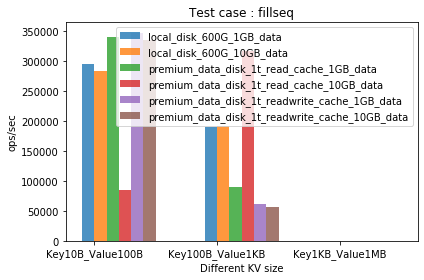

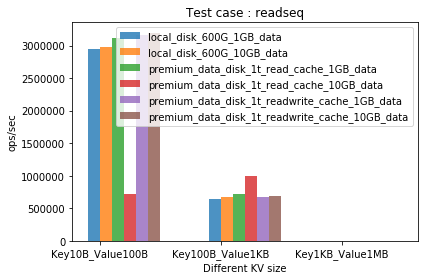

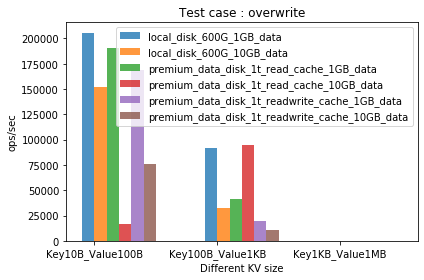

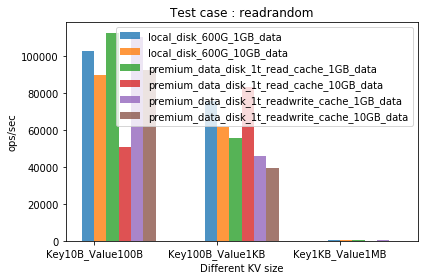

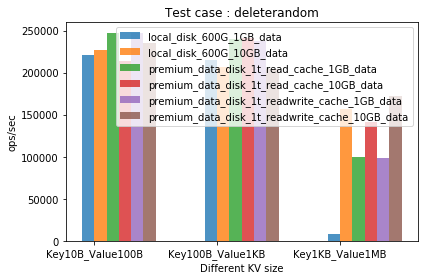

In [27]:
print("Throughput")
print_all(path_prefix = path_prefix, 
          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache", "premium_data_disk_1t_readwrite_cache"],
         data_sizes_names = ["1GB_data", "10GB_data"],
         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],
         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom", "deleterandom"],
         y_label = LOG_RES_OPS_SEC)
    

In [17]:
'''
print("P99 Latency")
print_all(path_prefix = path_prefix, 
          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache", "premium_data_disk_1t_readwrite_cache"],
         data_sizes_names = ["1GB_data", "10GB_data"],
         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],
         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom", "deleterandom"],
         y_label = LOG_RES_P99)
'''

'\nprint("P99 Latency")\nprint_all(path_prefix = path_prefix, \n          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache", "premium_data_disk_1t_readwrite_cache"],\n         data_sizes_names = ["1GB_data", "10GB_data"],\n         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],\n         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom", "deleterandom"],\n         y_label = LOG_RES_P99)\n'

In [18]:
'''
print("Local disk vs data disk with read cache")
print_all(path_prefix = path_prefix, 
          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache"],
         data_sizes_names = ["1GB_data", "10GB_data"],
         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],
         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom", "deleterandom"],
         y_label = LOG_RES_OPS_SEC)
'''

'\nprint("Local disk vs data disk with read cache")\nprint_all(path_prefix = path_prefix, \n          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache"],\n         data_sizes_names = ["1GB_data", "10GB_data"],\n         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],\n         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom", "deleterandom"],\n         y_label = LOG_RES_OPS_SEC)\n'

In [19]:
'''
print("Throughput")
print_all(path_prefix = path_prefix, 
          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache", "premium_data_disk_1t_readwrite_cache"],
         data_sizes_names = ["1GB_data", "10GB_data"],
         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],
         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom"],
         y_label = LOG_RES_THROUGHPUT)
'''

'\nprint("Throughput")\nprint_all(path_prefix = path_prefix, \n          disk_types = ["local_disk_600G", "premium_data_disk_1t_read_cache", "premium_data_disk_1t_readwrite_cache"],\n         data_sizes_names = ["1GB_data", "10GB_data"],\n         kv_names = ["Key10B_Value100B", "Key100B_Value1KB", "Key1KB_Value1MB"],\n         test_cases_names = ["fillseq", "readseq", "overwrite", "readrandom"],\n         y_label = LOG_RES_THROUGHPUT)\n'

In [20]:
def test_benchmark2_local_disk (data_size = 100 * GB):
    ROOT = "/mnt/db_data"
    DB_BENCH = "/home/fxie/rocksdb/db_bench"
    benchmark2(ROOT, DB_BENCH, data_size)
#test_benchmark2_local_disk()

In [40]:

def plot_benchmark(y_label, color = 'r'):
    
    def plot_bar(disk_names, results, y_label, title):
        y_pos = np.arange(len(disk_names))
        plt.bar(y_pos, results, align='center', alpha=0.5, color = color)
        plt.xticks(y_pos, disk_names)
        plt.ylabel(y_label)
        plt.title(title)
        plt.show()
        
    path_root = "/Users/fxie/Desktop/intern_project/samza-azure-storage/milestone2/rocks_db_benchmark_results2"
    disk_names = ["local_disk_result", "data_disk_read_cache", "data_disk_readwrite_cache"]

    for test_file_name in ["benchmark_bulkload_fillrandom.log", "benchmark_overwrite.t1.s0.log"]:
        results = []
        for disk_name in disk_names:
            parser = LogParser(file_name = f"{path_root}/{disk_name}/{test_file_name}")
            result = Result()
            parser.parse_all(result)
            results.append(result.res_map[y_label])
        plot_bar(disk_names, results, y_label, f"{test_file_name} | {y_label}")

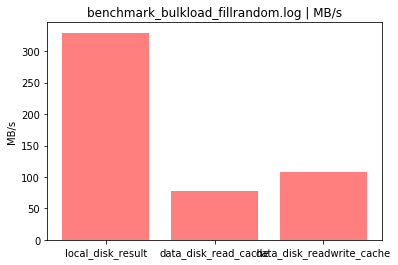

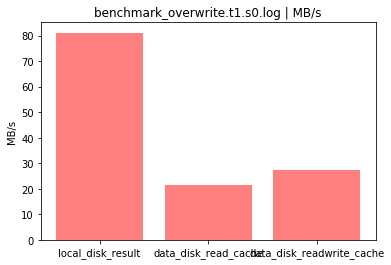

In [41]:
#LOG_RES_P99 = "P99"
#LOG_RES_OPS_SEC = "ops/sec"
#LOG_RES_THROUGHPUT = "MB/s"

plot_benchmark(LOG_RES_THROUGHPUT)

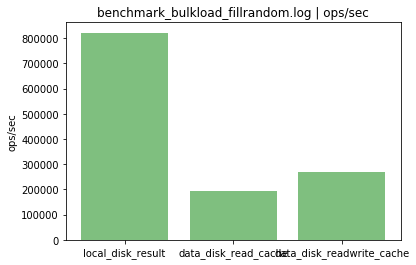

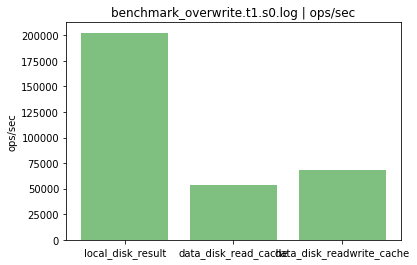

In [42]:
plot_benchmark(LOG_RES_OPS_SEC, color = 'g')

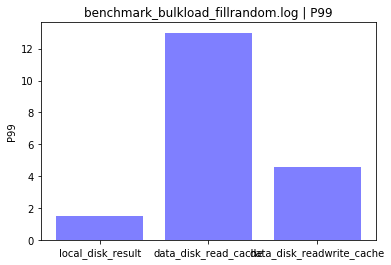

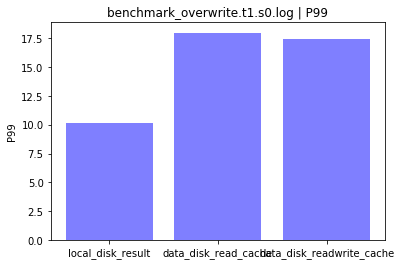

In [43]:
plot_benchmark(LOG_RES_P99, color = 'b')

In [8]:
'''
Use benchmark.sh instead of db_bench
'''
class Benchmark2():
    
    #export DB_DIR=/raid/db
    #export WAL_DIR=/raid/wal
    #export TEMP=/raid/tmp
    #export OUTPUT_DIR=/raid/output
  
    
    def __init__(self, test_dir, rocks_db_dir, para_map = {"KEY_SIZE":20, "VALUE_SIZE":400}, verbose=True):
        
        self.rocks_db_dir = rocks_db_dir
        run_cmd(f"cp {rocks_db_dir}/db_bench .")
        os.system("cd {rocks_db_dir}")
        self.benchmark_sh = f"{rocks_db_dir}/tools/benchmark.sh"
        self.para_map = para_map
        self.verbose = verbose
        self.test_dir = self.setup_test_env(test_dir)
        
    '''
    Bulkload:
        The keys are inserted in random order. 
        The database is empty at the beginning of this benchmark run and gradually fills up. 
        No data is being read when the data load is in progress.

        Rocksdb was configured to first load all the data in L0 with compactions switched off and using an unsorted vector memtable. 
        Then it made a second pass over the data to merge-sort all the files in L0 into sorted files in L1. 
        Here are the commands we used for loading the data into rocksdb:
    '''
    def bulkload(self):
        print("running bulk load")
        self.run_benchmark_sh("bulkload")
        print("bulk load done")

    def get_num_keys(self, data_size, key_size, value_size):
        return int(data_size / (key_size + value_size))


    def run_benchmark_sh(self, benchmarks):
        os.system(f"{self.form_parameter_string(self.para_map)} {self.benchmark_sh} {benchmarks}" )
        

    def setup_test_env(self, root_dir):
        test_dir = self.get_random_test_dir(root_dir)
        
        print("Setup a new test root. Test root dir {}".format(test_dir))
        self.create_new_dir(test_dir)
        
        return test_dir

    def create_new_dir(self, dir_name):
        os.system("rm -rf {}".format(dir_name))
        os.system("mkdir {}".format(dir_name))
        self.db_dir = f"{dir_name}/db"
        self.wal_dir = f"{dir_name}/wal"
        self.output_dir = f"{dir_name}/output"
        self.tmp_dir = f"{dir_name}/tmp"
        os.system("mkdir {}".format(self.db_dir))
        os.system("mkdir {}".format(self.wal_dir))
        os.system("mkdir {}".format(self.output_dir))
        os.system("mkdir {}".format(self.tmp_dir))
        self.para_map["DB_DIR"] = self.db_dir
        self.para_map["OUTPUT_DIR"] = self.output_dir
        self.para_map["WAL_DIR"] = self.wal_dir
        self.para_map["TEMP"] = self.tmp_dir
    
    def clean_up(self):
        os.system("rm -rf db_bench")

    def get_random_test_dir(self, root_dir):
        return "{}/test-{}".format(root_dir, random.randint(0, 1000000000))
    
    def form_parameter_string(self, kvs):
        res = ""
        for key, value in kvs.items():
            res = f"{res} {key}={value}"
        return res

In [21]:
def test_local_disk_without_compression():
    rocks_db_dir = "/home/fxie/rocksdb"
    test_dir = "/mnt/db_data"
    benchmark2 = Benchmark2(rocks_db_dir = rocks_db_dir, test_dir = test_dir)
    benchmark2.para_map["COMPRESSION_TYPE"] = "none"
    benchmark2.para_map["CACHE_SIZE"] = "104857600"
    benchmark2.para_map["NUM_KEYS"] = "250000000"
    benchmark2.bulkload()
    benchmark2.clean_up()

In [22]:
print("local disk without compression")
test_local_disk_without_compression()

local disk without compression
Setup a new test root. Test root dir /mnt/db_data/test-184258652
running bulk load
bulk load done


In [12]:
def test_data_disk_without_compression():
    rocks_db_dir = "/home/fxie/rocksdb"
    for test_dir in ["/no_cache", "/read_cache", "/readwrite_cache"]:
        print(f"test dir {test_dir}")
        benchmark2 = Benchmark2(rocks_db_dir = rocks_db_dir, test_dir = test_dir)
        benchmark2.para_map["COMPRESSION_TYPE"] = "none"
        benchmark2.para_map["CACHE_SIZE"] = "104857600"
        benchmark2.para_map["NUM_KEYS"] = "250000000"
        benchmark2.bulkload()
        benchmark2.clean_up()
        time.sleep(60)

In [13]:
test_data_disk_without_compression()

test dir /no_cache
Setup a new test root. Test root dir /no_cache/test-316393514
running bulk load
bulk load done
test dir /read_cache
Setup a new test root. Test root dir /read_cache/test-128304589
running bulk load
bulk load done
test dir /readwrite_cache
Setup a new test root. Test root dir /readwrite_cache/test-241147007
running bulk load
bulk load done


In [47]:
#path_root = "/Users/fxie/Desktop/intern_project/samza-azure-storage/milestone2/rocks_db_benchmark_results2"
#disk_names = ["local_disk_result", "data_disk_read_cache", "data_disk_readwrite_cache"]
# ["benchmark_bulkload_fillrandom.log", "benchmark_overwrite.t1.s0.log"]
def plot_bar(disk_names, results, y_label, title):
    y_pos = np.arange(len(disk_names))
    plt.bar(y_pos, results, align='center', alpha=0.5, color = color)
    plt.xticks(y_pos, disk_names)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def plot_benchmark2(y_label, path_root, disk_names, test_file_names, color = 'r'):
    
    
        
    
    for test_file_name in test_file_names:
        results = []
        for disk_name in disk_names:
            parser = LogParser(file_name = f"{path_root}/{disk_name}/{test_file_name}")
            result = Result()
            parser.parse_all(result)
            results.append(result.res_map[y_label])
        print(results)
        plot_bar(disk_names, results, y_label, f"{test_file_name} | {y_label}")

[345.9, 113.0, 112.9, 64.5]


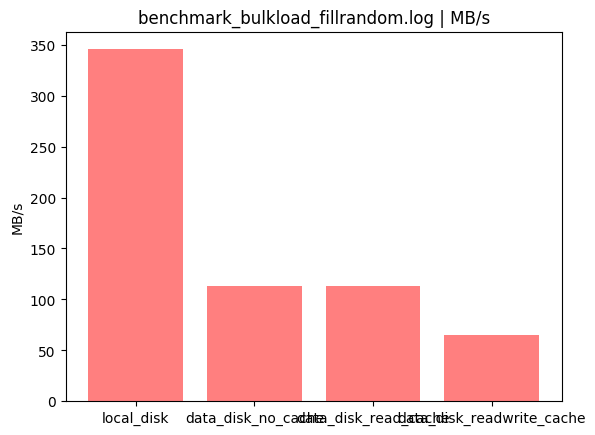

In [18]:
plot_benchmark2(y_label = LOG_RES_THROUGHPUT, 
                path_root = "/home/fxie/samza-azure-storage/milestone2/rocks_db_benchmark_result3_no_compression",
               disk_names = ["local_disk", "data_disk_no_cache", "data_disk_read_cache", "data_disk_readwrite_cache"],
               test_file_names = ["benchmark_bulkload_fillrandom.log"])

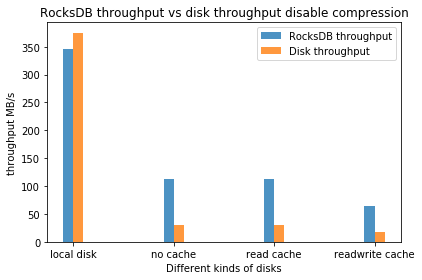

In [16]:
#def plot_bar_graph(y_label, title, disk_type_names, disk_results, x_label, kv_names):
plot_bar_graph("throughput MB/s", "RocksDB throughput vs disk throughput disable compression", 
               disk_type_names = ["RocksDB throughput", "Disk throughput"],
              disk_results = [[345.9, 113.0, 112.9, 64.5], [375, 30, 30, 17]], 
              x_label = "Different kinds of disks", 
              kv_names = ["local disk", "no cache", "read cache", "readwrite cache"])

In [21]:
def test_local_disk_with_compression():
    rocks_db_dir = "/home/fxie/rocksdb"
    test_dir = "/mnt/db_data"
    benchmark2 = Benchmark2(rocks_db_dir = rocks_db_dir, test_dir = test_dir)
    benchmark2.para_map["COMPRESSION_TYPE"] = "snappy"
    benchmark2.para_map["CACHE_SIZE"] = "104857600"
    benchmark2.para_map["NUM_KEYS"] = "250000000"
    benchmark2.bulkload()
    benchmark2.clean_up()

In [22]:
test_local_disk_with_compression()

Setup a new test root. Test root dir /mnt/db_data/test-216757652
running bulk load
bulk load done


In [9]:
def test_data_disk_with_compression():
    rocks_db_dir = "/home/fxie/rocksdb"
    for test_dir in ["/no_cache", "/read_cache", "/readwrite_cache"]:
        print(f"test dir {test_dir}")
        benchmark2 = Benchmark2(rocks_db_dir = rocks_db_dir, test_dir = test_dir)
        benchmark2.para_map["COMPRESSION_TYPE"] = "snappy"
        benchmark2.para_map["CACHE_SIZE"] = "104857600"
        benchmark2.para_map["NUM_KEYS"] = "250000000"
        benchmark2.bulkload()
        benchmark2.clean_up()
        time.sleep(60)

In [10]:
test_data_disk_with_compression()

test dir /no_cache
Setup a new test root. Test root dir /no_cache/test-318482217
running bulk load
bulk load done
test dir /read_cache
Setup a new test root. Test root dir /read_cache/test-160721534
running bulk load
bulk load done
test dir /readwrite_cache
Setup a new test root. Test root dir /readwrite_cache/test-950146144
running bulk load
bulk load done


[539.6, 197.4, 193.1, 121.6]


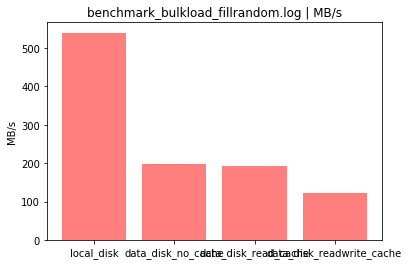

In [13]:
plot_benchmark2(y_label = LOG_RES_THROUGHPUT, 
                path_root = "/home/fxie/samza-azure-storage/milestone2/rocks_db_benchmark_result4_with_compression",
               disk_names = ["local_disk", "data_disk_no_cache", "data_disk_read_cache", "data_disk_readwrite_cache"],
               test_file_names = ["benchmark_bulkload_fillrandom.log"])

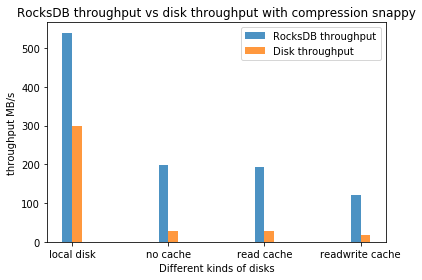

In [17]:
#def plot_bar_graph(y_label, title, disk_type_names, disk_results, x_label, kv_names):
plot_bar_graph("throughput MB/s", "RocksDB throughput vs disk throughput with compression snappy", 
               disk_type_names = ["RocksDB throughput", "Disk throughput"],
              disk_results = [[539.6, 197.4, 193.1, 121.6], [300, 28, 28, 17]], 
              x_label = "Different kinds of disks", 
              kv_names = ["local disk", "no cache", "read cache", "readwrite cache"])

In [81]:
class IOBenchmark():
  
    def __init__(self, block_size, data_size, output_dir, clean_up = True):
        self.block_size = block_size
        self.data_size = data_size
        self.output_dir = output_dir
        self.clean_up = clean_up
        self.count = self.get_block_count(self.data_size, self.block_size)
    
    '''
    Sequential write with 'dd' command
    '''
    def dd_sequential_write(self, output_file_name):
        print("running sequential_write")
        cmd = f"sync; dd if=/dev/zero of={output_file_name} bs={self.block_size} count={self.count}; sync"
        print(cmd)
        res = run_cmd(cmd, True)
        return res
    
    '''
    Sequential read with 'dd' command
    '''
    def dd_sequential_read(self, input_file_name):
        print("running sequential_read")
        cmd = f"dd if={input_file_name} of=/dev/null bs={self.block_size} count={self.count}"
        print(cmd)
        res = run_cmd(cmd, True)
        return res
    
    def dd_sequential_readwrite(self):
        print("sequential benchmark using dd")
        output_file_name = self.get_output_file_name("dd", self.output_dir)
        self.delete_file(output_file_name)
        write_res = self.dd_sequential_write(output_file_name)
        read_res = self.dd_sequential_read(output_file_name)
        if self.clean_up == True:
            self.delete_file(output_file_name)
        return read_res, write_res
    
    def fio_sequential_read(self, file_name):
        print("running sequential_read")
        cmd = f"fio -filename={file_name}   -rw=read  -bs={self.block_size} -size={self.data_size} -numjobs=1 -name=mytest\
         --output-format=json"
        print(cmd)
        res = run_cmd(cmd, True)
        return res
        
    def fio_sequential_write(self, file_name):
        print("running sequential_write")
        cmd = f"fio -filename={file_name} -rw=write -bs={self.block_size} -size={self.data_size} -numjobs=1 -name=mytest\
         --output-format=json"
        print(cmd)
        res = run_cmd(cmd, True)
        return res
    
    def fio_sequential_readwrite(self):
        print("sequential benchmark using fio")
        output_file_name = self.get_output_file_name("fio", self.output_dir)
        self.delete_file(output_file_name)
        write_res = self.fio_sequential_write(output_file_name)
        read_res = self.fio_sequential_read(output_file_name)
        if self.clean_up == True:
            self.delete_file(output_file_name)
        return read_res, write_res
    
    def fio_random_read(self, file_name):
        print("running random_read")
        cmd = f"fio -filename={file_name} -rw=randread -bs={self.block_size} -size={self.data_size} -numjobs=1 -name=mytest\
         --output-format=json "
        print(cmd)
        res = run_cmd(cmd, True)
        return res
        
    def fio_random_write(self, file_name):
        print("running random_write")
        cmd = f"fio -filename={file_name} -rw=randwrite -bs={self.block_size} -size={self.data_size} \
        -numjobs=1 -name=mytest --output-format=json"
        print(cmd)
        res = run_cmd(cmd, True)
        return res
    
    def fio_random_readwrite(self):
        print("random benchmark using fio")
        output_file_name = self.get_output_file_name("fio", self.output_dir)
        self.delete_file(output_file_name)
        write_res = self.fio_random_write(output_file_name)
        read_res = self.fio_random_read(output_file_name)
        if self.clean_up == True:
            self.delete_file(output_file_name)
        return read_res, write_res
    
    #example : dic["jobs"][0]["write"]["bw_mean"]
    def extract_throughput_mb(self, json_str, rw_type):
        dic = json.loads(json_str)
        res = float(dic["jobs"][0][rw_type]["bw"])
        return int(res / 1024)
    
    def delete_file(self, file_name):
        os.system(f"rm -rf {file_name}")
    
    def get_block_count(self, data_size, block_size):
        return int(data_size / block_size)  
        
    def get_output_file_name(self, tool_name, output_dir):
        file_name = f"{output_dir}/test-{tool_name}-{random.randint(0, 1000000000)}"
        return file_name

    def run_all_and_extract_throughput(self):
        fio_seq_read_res, fio_seq_write_res = self.fio_sequential_readwrite()
        fio_random_read_res, fio_random_write_res = self.fio_random_readwrite()
        seq_read_res = ioBenchmark.extract_throughput_mb(fio_seq_read_res, "read")
        seq_write_res = ioBenchmark.extract_throughput_mb(fio_seq_write_res, "write")
        random_read_res = ioBenchmark.extract_throughput_mb(fio_random_read_res, "read")
        random_write_res = ioBenchmark.extract_throughput_mb(fio_random_write_res, "write")
        print(f"seq read : {seq_read_res} MB/s. seq write : {seq_write_res} MB/s. \
          random read : {random_read_res} MB/s. random write : {random_write_res} MB/s")

In [83]:
#test in local disk
#23/July 4:01 PM
ioBenchmark = IOBenchmark(8192 * B, 100 * GB, "/mnt/db_data", True)
ioBenchmark.run_all_and_extract_throughput()

sequential benchmark using fio
running sequential_write
fio -filename=/mnt/db_data/test-fio-813056569 -rw=write -bs=8192 -size=107374182400 -numjobs=1 -name=mytest         --output-format=json
running sequential_read
fio -filename=/mnt/db_data/test-fio-813056569   -rw=read  -bs=8192 -size=107374182400 -numjobs=1 -name=mytest         --output-format=json
random benchmark using fio
running random_write
fio -filename=/mnt/db_data/test-fio-42306232 -rw=randwrite -bs=8192 -size=107374182400         -numjobs=1 -name=mytest --output-format=json
running random_read
fio -filename=/mnt/db_data/test-fio-42306232 -rw=randread -bs=8192 -size=107374182400 -numjobs=1 -name=mytest         --output-format=json 
seq read : 344 MB/s. seq write : 422 MB/s.           random read : 33 MB/s. random write : 155 MB/s


In [ ]:
for test_dir in ["/no_cache", "/read_cache", "/readwrite_cache"]:
    print(f"test dir {test_dir}")
    ioBenchmark = IOBenchmark()
    ioBenchmark.run_all_and_extract_throughput()
    print()